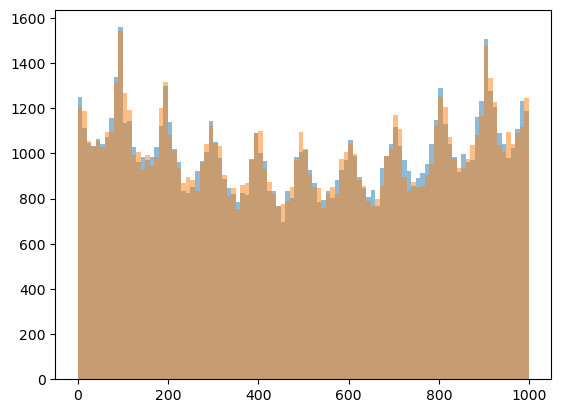

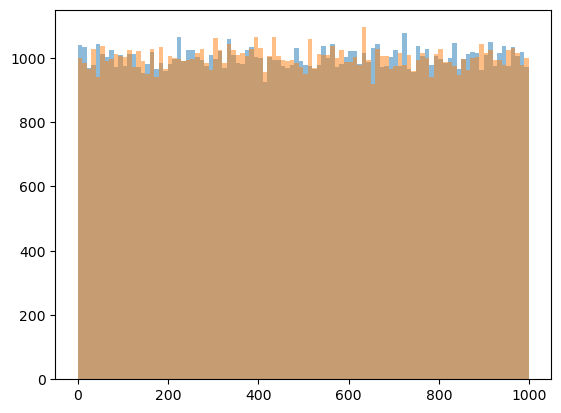

In [2]:
from lib.data import generate_sample
from matplotlib import pyplot as plt
from lib.config import config

for sampling_method in ['carry-first', 'uniform']:
    a_arr = []
    b_arr = []
    for i in range(100000):
        a, b, _ = generate_sample(config['n_digit'], sampling_method=sampling_method)
        a_arr.append(a)
        b_arr.append(b)

    plt.figure()
    plt.hist(a_arr, bins=100, alpha=0.5, label='a')
    plt.hist(b_arr, bins=100, alpha=0.5, label='b')
    plt.show()

# a_tally = []
# b_tally = []
# for _ in range(10000):
#     a, b, carries = generate_sample(3, 10)
#     a_digits, b_digits, carries_ = detect_carry(a, b, 10)
#     a_tally.append(a)
#     b_tally.append(b)

# make sure numbers are uniformly distributed
# mean should converge to (1000 - 0) / 2 = 500
# std should converge to sqrt((1000 - 0) ** 2 / 12) = 288.675134595
# print(np.mean(a_tally), np.std(a_tally), np.mean(b_tally), np.std(b_tally))

[3, 4, 3, 6, 3, 5, 3, 3, 4, 3]


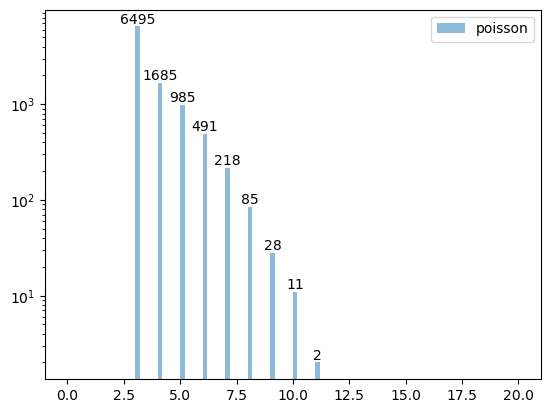

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from lib.utils.addition_utils import sample_n_digit_old

for dist in ['poisson']:
    samples = []
    for _ in range(10000):
        
        samples.append(sample_n_digit_old(3, dist, params=3.5))
    
    print(samples[:10])

    counts, edges, bars = plt.hist(samples, bins=100, alpha=0.5, label=dist, range=(0,20))
    plt.bar_label(bars)

plt.yscale('log')
plt.legend()
plt.show()


In [17]:
%load_ext autoreload
%autoreload 2

import os 
os.chdir('/workspaces/anaconda/transformer_arithmetic')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from lib.config import config
from lib.train import init_model
from lib.data import get_train_test_loaders

config['resume'] = False
config['wandb_log'] = False
config['device'] = 'cuda:0'
config['num_test'] = 1000
config['use_hookedtransformer'] = False
config['init_from'] = None
config['init_pretrained'] = False
config['batch_size'] = 10
model, it, best_val_acc, ckpt, encode, decode, vocab_size = init_model(config, compile_model=False)
train_dataloader, test_dataloaders, test_train_dataloader = get_train_test_loaders(encode, config)

print('Parameter count:', sum(p.numel() for p in model.parameters() if p.requires_grad))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
all the unique characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 96
Parameter count: 10782720


In [5]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(96, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=384, out_features=96, bias=False)
)


In [18]:
from lib.utils.condition_number import get_hessian_eigenvectors
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()
top_eigval, bot_eigval = get_hessian_eigenvectors(model, train_dataloader, num_batches=1, device=config['device'], n_vectors=10, param_extract_fn=None)

KeyboardInterrupt: 

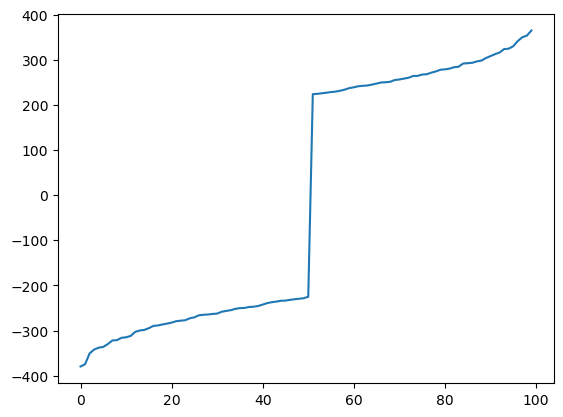

In [ ]:
from matplotlib import pyplot as plt

plt.plot(top_eigval, label='top')
plt.plot(bot_eigval, label='bot')


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils.waves import WaveGenerator
from lib.config import config

wg = WaveGenerator(length=128, chars=config['chars'], n_components=4, n_levels=8)

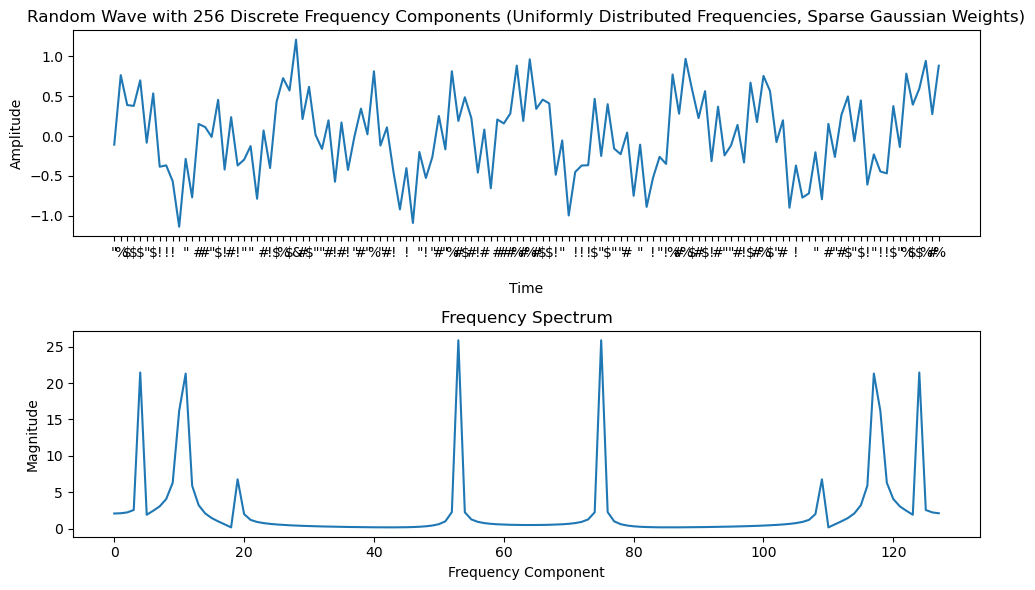

In [45]:
wave_str, wave = wg.sample()

# Compute FFT to get the frequency spectrum
spectrum = np.abs(np.fft.fft(wave))

# Plot the wave
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(wave)
plt.xticks(np.arange(wg.length), labels=wave_str)
plt.title("Random Wave with 256 Discrete Frequency Components (Uniformly Distributed Frequencies, Sparse Gaussian Weights)")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Plot the spectrum
plt.subplot(2, 1, 2)
plt.plot(np.arange(wg.length), spectrum[:wg.length])
plt.title("Frequency Spectrum")
plt.xlabel("Frequency Component")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


In [18]:
import numpy as np

# Function to quantize amplitude levels and map them to ASCII characters
def quantize_amplitude(amplitude, num_levels):
    min_amp = np.min(amplitude)
    max_amp = np.max(amplitude)
    amp_range = max_amp - min_amp
    step_size = amp_range / (num_levels - 1)
    quantized_amplitude = np.round((amplitude - min_amp) / step_size).astype(int)
    ascii_chars = list(map(chr, range(32, 127)))
    return ''.join([ascii_chars[level] for level in quantized_amplitude])

# Quantize amplitude levels and form a string of ASCII characters
quantized_wave_string = quantize_amplitude(wave, 20)

# Display the quantized wave string
print(repr(quantized_wave_string))


'-""-3+!#.2*!$/2)!$/2( %02\' &11& (20% )2/$!*2.#!+2-#",3,""-3+!#.3* $/2) %02\' &11& \'10%!(2/%!)2/$!*3.#!,3-""-3+!#.3*!$/2)!%02(!&01\' \'11& (20% )3/$!*3.#!,3-"",2,"#-2+!#.2*!$/2) %02\' &11& (20%!)2/$!*2.$!+3.#",3-""-3+!#.3*!$/2) %01( &11\' \'10& (20% )2/$!*3.#!,3-'


30201310203210231210301213201230201310203210231210301213201230201310203210231210301213201230201310203210231210301213201230201310


<BarContainer object of 128 artists>

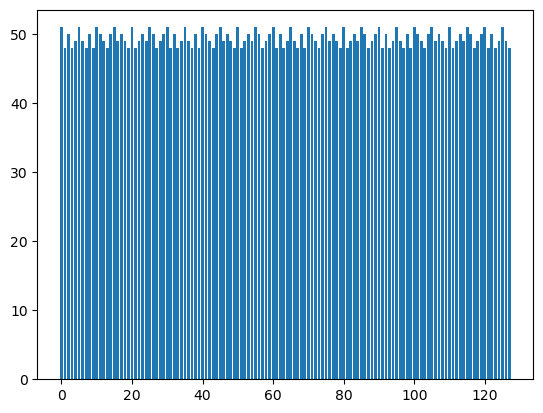

In [1]:
from lib.utils.waves import WaveGenerator2
from matplotlib import pyplot as plt
from lib.config import config

wg2 = WaveGenerator2(length=128, periods=[2, 2, 3, 5])

string = wg2.sample()

print(string)
plt.bar(range(128), list(map(ord, list(string))))


In [3]:
# 0a0a0a0a0a0a0a0a
# 0b00b00b00b00b00
# 00c0000c0000c000
# 0bcaba0c0abacb0a